In [1]:
from __future__ import division

from pylab import *

import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy
import time

import utils
import hrr_utils


from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import accuracy_score


plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [2]:
N = 100

In [3]:
alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)


def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.' 
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = ngram_encode_cl(pair[1], dic1, 3)
        past2 = ngram_encode_cl(pair[1], dic2, 3)
        pres1 = ngram_encode_cl(pair[0], dic1, 3)
        pres2 = ngram_encode_cl(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def train(tv, past, present):
    tv += np.multiply(past, present)
    return tv

def train_full(trainpast, trainpres):
    psi = np.zeros(N)
    tst = time.time()
    
    for k in range(len(trainpast)):
        psi = train(psi, trainpast[k], trainpres[k])

    print 'Elapsed: ', time.time()-tst
    return psi
   
def reg_train(tv, past, present):
    pred = np.multiply(tv, present)
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past))/float(N)) * np.multiply(past, present)
    return tv

def reg_train_full(trainpast, trainpres):
    psi = np.zeros(N)
    tst = time.time()
    for k in range(len(trainpast)):
        psi = reg_train(psi, trainpast[k], trainpres[k])
    print 'Elapsed: ', time.time()-tst
    return psi

def train_diff(tv, past2, present1, present2):
    tv += np.multiply(present1, past2-present2)
    return tv

def train_diff_full(trainpast2, trainpres1, trainpres2):
    psi = np.zeros(N)
    tst = time.time()
    
    for k in range(len(trainpast2)):
        psi = train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

    print 'Elapsed: ', time.time()-tst
    return psi


def reg_train_diff(tv, past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)
    return tv

def reg_train_diff_full(trainpast2, trainpres1, trainpres2):
    psi = np.zeros(N)
    tst = time.time()
    
    for k in range(len(trainpast2)):
        psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

    print 'Elapsed: ', time.time()-tst
    return psi

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)


In [4]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2/3.0

irregular_train_idx = int(train_frac*len(irreg_pres))
train_irreg = irregular[0:irregular_train_idx]

regular_train_idx = 1700 - len(train_irreg) 
train_reg = regular[0:regular_train_idx]

test_reg = regular[regular_train_idx:]
test_irreg = irregular[irregular_train_idx:]

#dic1 = hrr_utils.GenerateDefaultDictionary(N)
#dic2 = hrr_utils.GenerateDefaultDictionary(N)

D = len(alphabet)

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

regular.extend(irregular)
verbs = regular

In [5]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

In [6]:
trainpres1.shape

M = trainpres1.shape[0]

In [7]:
psi = reg_train_full(trainpast2, trainpres1)
tag='reg'

Elapsed:  0.02783203125


In [8]:
word_idx = 18
print train_reg[word_idx]

bound_vec = trainpres1[word_idx, :] * psi

print np.dot(bound_vec, trainpast2[word_idx, :])

('use', 'used', 228)
154.420023455


In [9]:
psi = reg_train_diff_full(trainpast2, trainpres1, trainpres2)


Elapsed:  0.0269510746002


In [10]:
word_idx = 28
print train_reg[word_idx]

bound_vec = trainpres1[word_idx, :] * psi + trainpres2[word_idx, :]
tag='reg_diff'
print np.dot(bound_vec, trainpast2[word_idx, :])

('need', 'needed', 160)
-471.951947468


In [11]:
bound_vec = trainpast2[word_idx, :]
tag='direct'

In [90]:
letter_vecs = dic2
#letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


#ngram_str = 'powers'
#bound_vec = ngram_encode(ngram_str, letter_vecs, alph)
#bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)

# initializing the states as random works just as well as the intention, which
# is to initialize as the superposition of all D states.
l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)
l5_state = np.random.randn(N)
l6_state = np.random.randn(N)
l7_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))
l4_state = np.dot(letter_vecs.T, np.dot(l4_state, letter_vecs.T))
l5_state = np.dot(letter_vecs.T, np.dot(l5_state, letter_vecs.T))
l6_state = np.dot(letter_vecs.T, np.dot(l6_state, letter_vecs.T))
l7_state = np.dot(letter_vecs.T, np.dot(l7_state, letter_vecs.T))

# the clipping non-linearity will lead to arbitrary norms, so need to keep vector normalized
l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)
l4_state = l4_state/norm(l4_state)
l5_state = l5_state/norm(l5_state)
l6_state = l6_state/norm(l6_state)
l7_state = l7_state/norm(l7_state)

# we know the first letter
l0_state = letter_vecs[alphabet.find('#'), :]


n_steps = 100

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))
l4_coef_hist = np.zeros((n_steps, D))
l5_coef_hist = np.zeros((n_steps, D))
l6_coef_hist = np.zeros((n_steps, D))
l7_coef_hist = np.zeros((n_steps, D))

In [91]:
tst = time.time()
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    l4_coef_hist[i, :] = np.dot(letter_vecs, l4_state)
    l5_coef_hist[i, :] = np.dot(letter_vecs, l5_state)
    l6_coef_hist[i, :] = np.dot(letter_vecs, l6_state)
    l7_coef_hist[i, :] = np.dot(letter_vecs, l7_state)

    ## Need to make sure that the largest absolute value is always positive,
    ## because the unbinding inference can flip 2 and be the same
    
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l1_state = l1_state * np.sign(l1_coef_hist[i, mx1idx])
    #l1_coef_hist[i, :] *= np.sign(l1_coef_hist[i, mx1idx])
    
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l2_state = l2_state *  np.sign(l2_coef_hist[i, mx2idx])
    #l2_coef_hist[i, :] *= np.sign(l2_coef_hist[i, mx1idx])
    
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l3_state = l3_state * np.sign(l3_coef_hist[i, mx3idx])
    #l3_coef_hist[i, :] *= np.sign(l3_coef_hist[i, mx1idx])
    
    mx4idx = np.argmax(np.abs(l4_coef_hist[i,:]))
    l4_state = l4_state * np.sign(l4_coef_hist[i, mx4idx])
    #l4_coef_hist[i, :] *= np.sign(l4_coef_hist[i, mx1idx])
    
    mx5idx = np.argmax(np.abs(l5_coef_hist[i,:]))
    l5_state = l5_state * np.sign(l5_coef_hist[i, mx5idx])
    #l5_coef_hist[i, :] *= np.sign(l5_coef_hist[i, mx1idx])
    
    mx6idx = np.argmax(np.abs(l6_coef_hist[i,:]))
    l6_state = l6_state * np.sign(l6_coef_hist[i, mx6idx])
    #l6_coef_hist[i, :] *= np.sign(l6_coef_hist[i, mx1idx])
    
    mx7idx = np.argmax(np.abs(l7_coef_hist[i,:]))
    l7_state = l7_state * np.sign(l7_coef_hist[i, mx7idx])
    #l7_coef_hist[i, :] *= np.sign(l7_coef_hist[i, mx1idx])
    
    
    l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2)) / 2

    l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
              bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2)) / 3

    l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2) +
              bound_vec * np.roll(l4_state, 1) * np.roll(l5_state, 2)) / 3
    
    l4d = (np.roll(bound_vec * l2_state * np.roll(l3_state, 1), -2) +
            np.roll(bound_vec * l3_state * np.roll(l5_state, 2), -1) +
              bound_vec * np.roll(l5_state, 1) * np.roll(l6_state, 2)) / 3

    l5d = (np.roll(bound_vec * l4_state * np.roll(l6_state, 2), -1) +
           np.roll(bound_vec * l3_state * np.roll(l4_state, 1), -2) +
              bound_vec * np.roll(l6_state, 1) * np.roll(l7_state, 2)) / 3
    
    l6d = (np.roll(bound_vec * l5_state * np.roll(l7_state, 2), -1) +
           np.roll(bound_vec * l4_state * np.roll(l5_state, 1), -2)) / 2
    
    l7d = (np.roll(bound_vec * l5_state * np.roll(l6_state, 1), -2))

    l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N)
    l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N)
    l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N)
    l4_state = np.dot(letter_vecs.T, np.dot(l4d, letter_vecs.T)/N)
    l5_state = np.dot(letter_vecs.T, np.dot(l5d, letter_vecs.T)/N)
    l6_state = np.dot(letter_vecs.T, np.dot(l6d, letter_vecs.T)/N)
    l7_state = np.dot(letter_vecs.T, np.dot(l7d, letter_vecs.T)/N)


    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)
    l4_state = l4_state/norm(l4_state)
    l5_state = l5_state/norm(l5_state)
    l6_state = l6_state/norm(l6_state)
    l7_state = l7_state/norm(l7_state)

print 'Elapsed:', time.time() - tst

Elapsed: 29.1174879074


needede
encoding_resonance_170314-res_example-need-N=100000-direct-M=1889-n170426


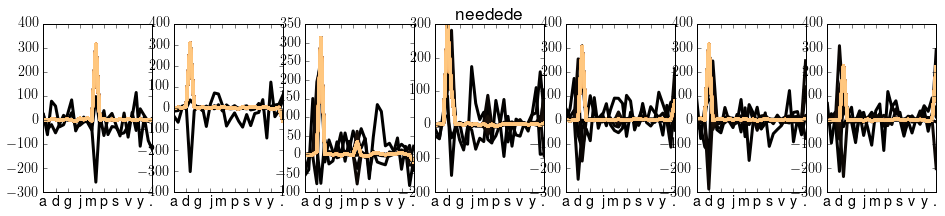

In [92]:
figure(figsize=(16,3))
cols = get_cmap('copper', n_steps)
alph = np.array(list(alphabet))
xv = arange(0, len(alph), 3)

lv = alph[xv]

for i in range(n_steps):
    ax=subplot(171)
    plot(-l1_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(172)
    plot(-l2_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(173)
    plot(-l3_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(174)
    plot(-l4_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(175)
    plot(-l5_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(176)
    plot(-l6_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(177)
    plot(-l7_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    
    
l1 = alph[np.argmax(np.abs(l1_coef_hist[-1,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[-1,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[-1,:]))]
l4 = alph[np.argmax(np.abs(l4_coef_hist[-1,:]))]
l5 = alph[np.argmax(np.abs(l5_coef_hist[-1,:]))]
l6 = alph[np.argmax(np.abs(l6_coef_hist[-1,:]))]
l7 = alph[np.argmax(np.abs(l7_coef_hist[-1,:]))]

result = l1+l2+l3+l4+l5+l6+l7
print result

subplot(174)
title(result)

fname = ('encoding_resonance_170314-res_example-' + train_reg[word_idx][0] + '-N='  + str(N) 
         + '-' + tag + '-M=' + str(M) + '-n' + time.strftime('%y%m%d'))

print fname

savefig(fname + '.eps', format='eps', transparent=True)
savefig(fname + '.png', format='png', transparent=True)


In [12]:
tst = time.time()

psi = np.zeros(N)
psi = train(psi, trainpast2[0], trainpres1[0])

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
#random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
#y3 = np.zeros(trainpres1.shape[0])
for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    #random_hist[k, :] = sim(random_vecs, testpast2)
    
    psi = train(psi, trainpast2[k], trainpres1[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/encoding_resonance_170314-trigram_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
#np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist)

Elapsed:  2.54536008835
data/encoding_resonance_170314-trigram_dict-unreg-N=100-W=1889-170502.npz


## figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
#random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
#random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='upper left')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Dictionary, Unregularized')

xlim([0, 1700])

plt.tight_layout()

fname =  ('figures/encoding_resonance_170314-trigram_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [13]:
tst = time.time()

cycle=1
psi = np.zeros(N)
psi = reg_train(psi, trainpast2[0], trainpres1[0])

#random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
#random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    #random_hist[k, :] = sim(random_vecs, testpast2)
    
    psi = reg_train(psi, trainpast2[k], trainpres1[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/encoding_resonance_170314-trigram_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
#np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist)

Elapsed:  2.0521979332
data/encoding_resonance_170314-trigram_dict-reg-N=100-W=1889-170502.npz


figures/encoding_resonance_170314-trigram_dict-reg-N=100-W=1889-170502


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


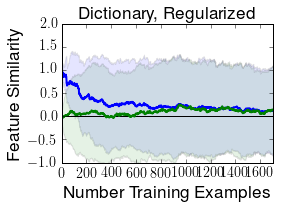

In [18]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
xticks(rotation=45)
    
train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
#random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
#random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc=legend,fontsize=12)

xlabel('Number Training Examples',fontsize=16)
ylabel('Feature Similarity',fontsize=16)
title('Dictionary, Regularized',fontsize=16)

xlim([0, 1700])
ylim([-1,2])

plt.tight_layout()

fname =  ('figures/encoding_resonance_170314-trigram_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [79]:
total_vec = perceptron_map_train(encoded)

NameError: name 'perceptron_map_train' is not defined

In [27]:
idx = 51
print words[idx], past_tense[idx]
np.dot(total_vec * encoded[idx][0], encoded[idx][1])

bound_vec = total_vec * encoded[idx][0]

NameError: name 'words' is not defined

In [28]:
idx = find([w=='leap' for w in words])[0]

print words[idx], past_tense[idx]
np.dot(total_vec * encoded[idx][0], encoded[idx][1])
bound_vec = total_vec * encoded[idx][0]


NameError: name 'words' is not defined

In [29]:
from pylab import *

def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1
    

In [30]:
mst=0
men=900
M=men-mst

total_vec = perceptron_map_train(encoded[mst:men])

NameError: name 'perceptron_map_train' is not defined

In [31]:
idx = 51
print words[idx], past_tense[idx]
np.dot(total_vec * encoded[idx][0], encoded[idx][1])

NameError: name 'words' is not defined

In [32]:
letter_vecs = RI_past
#letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


#ngram_str = 'powers'
#bound_vec = ngram_encode(ngram_str, letter_vecs, alph)
#bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)

# initializing the states as random works just as well as the intention, which
# is to initialize as the superposition of all D states.
l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)
l5_state = np.random.randn(N)
l6_state = np.random.randn(N)
l7_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))
l4_state = np.dot(letter_vecs.T, np.dot(l4_state, letter_vecs.T))
l5_state = np.dot(letter_vecs.T, np.dot(l5_state, letter_vecs.T))
l6_state = np.dot(letter_vecs.T, np.dot(l6_state, letter_vecs.T))
l7_state = np.dot(letter_vecs.T, np.dot(l7_state, letter_vecs.T))

# the clipping non-linearity will lead to arbitrary norms, so need to keep vector normalized
l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)
l4_state = l4_state/norm(l4_state)
l5_state = l5_state/norm(l5_state)
l6_state = l6_state/norm(l6_state)
l7_state = l7_state/norm(l7_state)

# we know the first letter
l0_state = letter_vecs[alphabet.find('#'), :]


n_steps = 100

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))
l4_coef_hist = np.zeros((n_steps, D))
l5_coef_hist = np.zeros((n_steps, D))
l6_coef_hist = np.zeros((n_steps, D))
l7_coef_hist = np.zeros((n_steps, D))

NameError: name 'RI_past' is not defined

In [33]:
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    l4_coef_hist[i, :] = np.dot(letter_vecs, l4_state)
    l5_coef_hist[i, :] = np.dot(letter_vecs, l5_state)
    l6_coef_hist[i, :] = np.dot(letter_vecs, l6_state)
    l7_coef_hist[i, :] = np.dot(letter_vecs, l7_state)

    ## Need to make sure that the largest absolute value is always positive,
    ## because the unbinding inference can flip 2 and be the same
    
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l1_state = l1_state * np.sign(l1_coef_hist[i, mx1idx])
    #l1_coef_hist[i, :] *= np.sign(l1_coef_hist[i, mx1idx])
    
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l2_state = l2_state *  np.sign(l2_coef_hist[i, mx2idx])
    #l2_coef_hist[i, :] *= np.sign(l2_coef_hist[i, mx1idx])
    
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l3_state = l3_state * np.sign(l3_coef_hist[i, mx3idx])
    #l3_coef_hist[i, :] *= np.sign(l3_coef_hist[i, mx1idx])
    
    mx4idx = np.argmax(np.abs(l4_coef_hist[i,:]))
    l4_state = l4_state * np.sign(l4_coef_hist[i, mx4idx])
    #l4_coef_hist[i, :] *= np.sign(l4_coef_hist[i, mx1idx])
    
    mx5idx = np.argmax(np.abs(l5_coef_hist[i,:]))
    l5_state = l5_state * np.sign(l5_coef_hist[i, mx5idx])
    #l5_coef_hist[i, :] *= np.sign(l5_coef_hist[i, mx1idx])
    
    mx6idx = np.argmax(np.abs(l6_coef_hist[i,:]))
    l6_state = l6_state * np.sign(l6_coef_hist[i, mx6idx])
    #l6_coef_hist[i, :] *= np.sign(l6_coef_hist[i, mx1idx])
    
    mx7idx = np.argmax(np.abs(l7_coef_hist[i,:]))
    l7_state = l7_state * np.sign(l7_coef_hist[i, mx7idx])
    #l7_coef_hist[i, :] *= np.sign(l7_coef_hist[i, mx1idx])
    
    
    l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2)) / 2

    l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
              bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2)) / 3

    l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2) +
              bound_vec * np.roll(l4_state, 1) * np.roll(l5_state, 2)) / 3
    
    l4d = (np.roll(bound_vec * l2_state * np.roll(l3_state, 1), -2) +
            np.roll(bound_vec * l3_state * np.roll(l5_state, 2), -1) +
              bound_vec * np.roll(l5_state, 1) * np.roll(l6_state, 2)) / 3

    l5d = (np.roll(bound_vec * l4_state * np.roll(l6_state, 2), -1) +
           np.roll(bound_vec * l3_state * np.roll(l4_state, 1), -2) +
              bound_vec * np.roll(l6_state, 1) * np.roll(l7_state, 2)) / 3
    
    l6d = (np.roll(bound_vec * l5_state * np.roll(l7_state, 2), -1) +
           np.roll(bound_vec * l4_state * np.roll(l5_state, 1), -2)) / 2
    
    l7d = (np.roll(bound_vec * l5_state * np.roll(l6_state, 1), -2))

    l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N)
    l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N)
    l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N)
    l4_state = np.dot(letter_vecs.T, np.dot(l4d, letter_vecs.T)/N)
    l5_state = np.dot(letter_vecs.T, np.dot(l5d, letter_vecs.T)/N)
    l6_state = np.dot(letter_vecs.T, np.dot(l6d, letter_vecs.T)/N)
    l7_state = np.dot(letter_vecs.T, np.dot(l7d, letter_vecs.T)/N)


    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)
    l4_state = l4_state/norm(l4_state)
    l5_state = l5_state/norm(l5_state)
    l6_state = l6_state/norm(l6_state)
    l7_state = l7_state/norm(l7_state)



needede


NameError: name 'words' is not defined

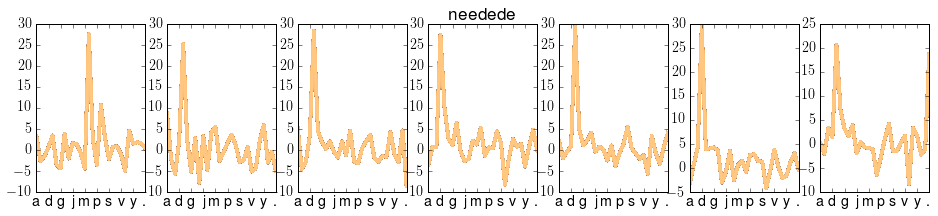

In [34]:
figure(figsize=(16,3))
cols = get_cmap('copper', n_steps)
xv = arange(0, len(alph), 3)
alph = np.array(list(alphabet))
lv = alph[xv]

for i in range(n_steps):
    ax=subplot(171)
    plot(-l1_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(172)
    plot(-l2_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(173)
    plot(-l3_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(174)
    plot(-l4_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(175)
    plot(-l5_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(176)
    plot(-l6_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(177)
    plot(-l7_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    
    
l1 = alph[np.argmax(np.abs(l1_coef_hist[-1,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[-1,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[-1,:]))]
l4 = alph[np.argmax(np.abs(l4_coef_hist[-1,:]))]
l5 = alph[np.argmax(np.abs(l5_coef_hist[-1,:]))]
l6 = alph[np.argmax(np.abs(l6_coef_hist[-1,:]))]
l7 = alph[np.argmax(np.abs(l7_coef_hist[-1,:]))]

result = l1+l2+l3+l4+l5+l6+l7
print result

subplot(174)
title(result)

fname = 'encoding_resonance_170314-res_example-' + words[idx] + '-N='  + str(N) + '-M=' + str(M) + '-n' + time.strftime('%y%m%d')
print fname

savefig(fname + '.eps', format='eps', transparent=True)
savefig(fname + '.png', format='png', transparent=True)


In [35]:
from tempfile import NamedTemporaryFile
from matplotlib import animation

from matplotlib.collections import LineCollection, CircleCollection


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

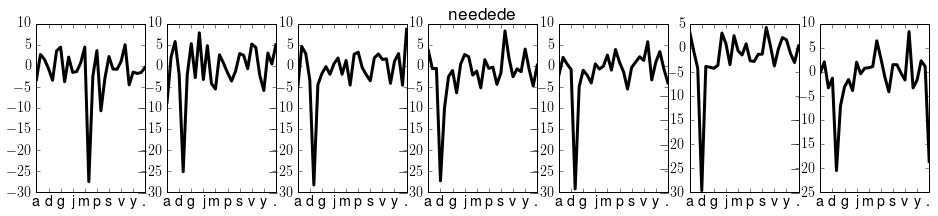

In [36]:
fh = figure(figsize=(16,3))
fh.clf()
cols = get_cmap('copper', n_steps)
xv = arange(0, len(alph), 3)
alphabet = np.array(list(alph))
lv = alphabet[xv]

ax1=fh.add_subplot(171)
ax2=fh.add_subplot(172)
ax3=fh.add_subplot(173)
ax4=fh.add_subplot(174)
ax5=fh.add_subplot(175)
ax6=fh.add_subplot(176)
ax7=fh.add_subplot(177)

ax1.set_xticks(xv)
ax1.set_xticklabels(lv)

ax2.set_xticks(xv)
ax2.set_xticklabels(lv)

ax3.set_xticks(xv)
ax3.set_xticklabels(lv)

ax4.set_xticks(xv)
ax4.set_xticklabels(lv)

ax5.set_xticks(xv)
ax5.set_xticklabels(lv)

ax6.set_xticks(xv)
ax6.set_xticklabels(lv)

ax7.set_xticks(xv)
ax7.set_xticklabels(lv)
    

ax1.plot(l1_coef_hist[0,:], lw=3, c=cols(0))
ax2.plot(l2_coef_hist[0,:], lw=3, c=cols(0))
ax3.plot(l3_coef_hist[0,:], lw=3, c=cols(0))
ax4.plot(l4_coef_hist[0,:], lw=3, c=cols(0))
ax5.plot(l5_coef_hist[0,:], lw=3, c=cols(0))
ax6.plot(l6_coef_hist[0,:], lw=3, c=cols(0))
ax7.plot(l7_coef_hist[0,:], lw=3, c=cols(0))


l1 = alph[np.argmax(np.abs(l1_coef_hist[0,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[0,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[0,:]))]
l4 = alph[np.argmax(np.abs(l4_coef_hist[0,:]))]
l5 = alph[np.argmax(np.abs(l5_coef_hist[0,:]))]
l6 = alph[np.argmax(np.abs(l6_coef_hist[0,:]))]
l7 = alph[np.argmax(np.abs(l7_coef_hist[0,:]))]

result = l1+l2+l3+l4+l5+l6+l7
ax4.set_title(result)



In [37]:
def animate_cl(i):
    #tstart =time.time()

    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    ax7.clear()
    
    ax1.plot(-l1_coef_hist[i,:], lw=3, c=cols(i))
    ax2.plot(-l2_coef_hist[i,:], lw=3, c=cols(i))
    ax3.plot(-l3_coef_hist[i,:], lw=3, c=cols(i))
    ax4.plot(-l4_coef_hist[i,:], lw=3, c=cols(i))
    ax5.plot(-l5_coef_hist[i,:], lw=3, c=cols(i))
    ax6.plot(-l6_coef_hist[i,:], lw=3, c=cols(i))
    ax7.plot(-l7_coef_hist[i,:], lw=3, c=cols(i))

    
    l1 = alph[np.argmax(np.abs(l1_coef_hist[i,:]))]
    l2 = alph[np.argmax(np.abs(l2_coef_hist[i,:]))]
    l3 = alph[np.argmax(np.abs(l3_coef_hist[i,:]))]
    l4 = alph[np.argmax(np.abs(l4_coef_hist[i,:]))]
    l5 = alph[np.argmax(np.abs(l5_coef_hist[i,:]))]
    l6 = alph[np.argmax(np.abs(l6_coef_hist[i,:]))]
    l7 = alph[np.argmax(np.abs(l7_coef_hist[i,:]))]

    #result = l1+l2+l3+l4+l5+l6+l7
    #ax4.set_title(result)
    
    ax1.set_title(l1)
    ax2.set_title(l2)
    ax3.set_title(l3)
    ax4.set_title(l4)
    ax5.set_title(l5)
    ax6.set_title(l6)
    ax7.set_title(l7)
    
    ax1.set_xticks(xv)
    ax1.set_xticklabels(lv)
    ax1.set_yticks([])

    ax2.set_xticks(xv)
    ax2.set_xticklabels(lv)
    ax2.set_yticks([])

    ax3.set_xticks(xv)
    ax3.set_xticklabels(lv)
    ax3.set_yticks([])
    
    ax4.set_xticks(xv)
    ax4.set_xticklabels(lv)
    ax4.set_yticks([])
    
    ax5.set_xticks(xv)
    ax5.set_xticklabels(lv)
    ax5.set_yticks([])
    
    ax6.set_xticks(xv)
    ax6.set_xticklabels(lv)
    ax6.set_yticks([])
    
    ax7.set_xticks(xv)
    ax7.set_xticklabels(lv)
    ax7.set_yticks([])
    
    ax1.set_xlim([0, len(alph)])
    ax1.set_ylim([-300, 400])
    ax2.set_xlim([0, len(alph)])
    ax2.set_ylim([-300, 400])
    ax3.set_xlim([0, len(alph)])
    ax3.set_ylim([-300, 400])
    ax4.set_xlim([0, len(alph)])
    ax4.set_ylim([-300, 400])
    ax5.set_xlim([0, len(alph)])
    ax5.set_ylim([-300, 400])
    ax6.set_xlim([0, len(alph)])
    ax6.set_ylim([-300, 400])
    ax7.set_xlim([0, len(alph)])
    ax7.set_ylim([-300, 400])
    
    
    print i,

tanim = time.time()
anim = animation.FuncAnimation(fh, animate_cl, frames=300, blit=False)
#display_animation(anim)
fname = 'encoding_resonance_170314-resonance_animation-clear-'  + words[idx] + '-N='  + str(N) + '-M=' + str(M) + '-n' + time.strftime('%y%m%d') + '.mp4'
print fname
anim.save(fname, fps=10, extra_args=['-vcodec', 'libx264'])
print ('\ntotal time: %2.2f ms' % (1000*(time.time() - tanim)))


NameError: name 'words' is not defined

In [38]:
def animate(i):
    #tstart =time.time()

    #ax1.clear()
    #ax2.clear()
    #ax3.clear()
    #ax4.clear()
    #ax5.clear()
    #ax6.clear()
    #ax7.clear()
    
    ax1.plot(l1_coef_hist[i,:], lw=3, c=cols(i))
    ax2.plot(l2_coef_hist[i,:], lw=3, c=cols(i))
    ax3.plot(l3_coef_hist[i,:], lw=3, c=cols(i))
    ax4.plot(l4_coef_hist[i,:], lw=3, c=cols(i))
    ax5.plot(l5_coef_hist[i,:], lw=3, c=cols(i))
    ax6.plot(l6_coef_hist[i,:], lw=3, c=cols(i))
    ax7.plot(l7_coef_hist[i,:], lw=3, c=cols(i))

    
    l1 = alph[np.argmax(np.abs(l1_coef_hist[i,:]))]
    l2 = alph[np.argmax(np.abs(l2_coef_hist[i,:]))]
    l3 = alph[np.argmax(np.abs(l3_coef_hist[i,:]))]
    l4 = alph[np.argmax(np.abs(l4_coef_hist[i,:]))]
    l5 = alph[np.argmax(np.abs(l5_coef_hist[i,:]))]
    l6 = alph[np.argmax(np.abs(l6_coef_hist[i,:]))]
    l7 = alph[np.argmax(np.abs(l7_coef_hist[i,:]))]

    result = l1+l2+l3+l4+l5+l6+l7
    ax4.set_title(result)
    print i,

tanim = time.time()
anim = animation.FuncAnimation(fh, animate, frames=300, blit=False)
fname = 'encoding_resonance_170314-resonance_animation-'  + words[idx] + '-N='  + str(N) + '-M=' + str(M) + '-n' + time.strftime('%y%m%d') + '.mp4'
print fname
anim.save(fname, fps=10, extra_args=['-vcodec', 'libx264'])

print ('\ntotal time: %2.2f ms' % (1000*(time.time() - tanim)))


NameError: name 'words' is not defined

In [39]:
irreg = read_csv("wickle_train/irregular_verbs.csv")

np.random.shuffle(irreg)

irreg_past_tense, irreg_words = [], []
for row in irreg:
    irreg_words.append(row[0])
    irreg_past_tense.append(row[1])
    
    
test_irreg_past_tense = irreg_past_tense[:30]
test_irreg_words = irreg_words[:30]

irreg_past_tense = irreg_past_tense[30:]
irreg_words = irreg_words[30:]

NameError: name 'read_csv' is not defined

In [40]:
print test_irreg_words

NameError: name 'test_irreg_words' is not defined

In [41]:
# train and test with only irregular verbs
irreg_encoded = encodes(irreg_words, irreg_past_tense)
test_irreg_encoded = encodes(test_irreg_words, test_irreg_past_tense)

NameError: name 'encodes' is not defined

In [42]:
graph(perceptron_map_train, irreg_encoded, test_irreg_encoded)

NameError: name 'graph' is not defined

In [43]:
# train and test appended to regular verbs
all_encoded = irreg_encoded + encoded

all_past_words = irreg_past_tense + past_tense

test_all_encoded = test_irreg_encoded + test_encoded

all_words = irreg_words + words

all_test_words = test_irreg_words + test_words
all_past_test_words = test_irreg_past_tense + test_past_tense

M = len(all_encoded)

total_vec = perceptron_map_train(all_encoded)

NameError: name 'irreg_encoded' is not defined

In [44]:

M = len(irreg_encoded)

total_vec = perceptron_map_train(irreg_encoded)

NameError: name 'irreg_encoded' is not defined

In [45]:
idx = 540
print all_words[idx], all_past_words[idx]
np.dot(total_vec * all_encoded[idx][0], all_encoded[idx][1])

NameError: name 'all_words' is not defined

In [46]:
print zip(irreg_words, irreg_past_tense)

NameError: name 'irreg_words' is not defined

In [47]:
print irreg_past_tense

NameError: name 'irreg_past_tense' is not defined

In [48]:
print test_irreg_words

NameError: name 'test_irreg_words' is not defined

In [49]:
print test_irreg_past_tense

NameError: name 'test_irreg_past_tense' is not defined

In [50]:
idx = 49

print irreg_words[idx], irreg_past_tense[idx]
np.dot(total_vec * irreg_encoded[idx][0], irreg_encoded[idx][1])

NameError: name 'irreg_words' is not defined

In [51]:
for idx in range(len(test_irreg_words)):
    print test_irreg_words[idx], test_irreg_past_tense[idx], np.dot(total_vec * test_irreg_encoded[idx][0], test_irreg_encoded[idx][1])

NameError: name 'test_irreg_words' is not defined

In [52]:
idx = 16
print test_irreg_words[idx], test_irreg_past_tense[idx]
print np.dot(total_vec * test_irreg_encoded[idx][0], test_irreg_encoded[idx][1])

NameError: name 'test_irreg_words' is not defined

In [53]:
idx = 2

print test_irreg_words[idx], test_irreg_past_tense[idx]

np.dot(total_vec * test_irreg_encoded[idx][0], test_irreg_encoded[idx][1])

NameError: name 'test_irreg_words' is not defined

In [54]:
bound_vec = total_vec * all_encoded[idx][0]


NameError: name 'total_vec' is not defined

In [55]:
bound_vec = total_vec * irreg_encoded[idx][0]
all_words = irreg_words

NameError: name 'total_vec' is not defined

In [56]:
bound_vec = total_vec * test_irreg_encoded[idx][0]
all_words = test_irreg_words

NameError: name 'total_vec' is not defined

In [57]:
letter_vecs = RI_past
#letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


#ngram_str = 'powers'
#bound_vec = ngram_encode(ngram_str, letter_vecs, alph)
#bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)

# initializing the states as random works just as well as the intention, which
# is to initialize as the superposition of all D states.
l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)
l5_state = np.random.randn(N)
l6_state = np.random.randn(N)
l7_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))
l4_state = np.dot(letter_vecs.T, np.dot(l4_state, letter_vecs.T))
l5_state = np.dot(letter_vecs.T, np.dot(l5_state, letter_vecs.T))
l6_state = np.dot(letter_vecs.T, np.dot(l6_state, letter_vecs.T))
l7_state = np.dot(letter_vecs.T, np.dot(l7_state, letter_vecs.T))

# the clipping non-linearity will lead to arbitrary norms, so need to keep vector normalized
l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)
l4_state = l4_state/norm(l4_state)
l5_state = l5_state/norm(l5_state)
l6_state = l6_state/norm(l6_state)
l7_state = l7_state/norm(l7_state)

# we know the first letter
l0_state = letter_vecs[alphabet.find('#'), :]


n_steps = 50

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))
l4_coef_hist = np.zeros((n_steps, D))
l5_coef_hist = np.zeros((n_steps, D))
l6_coef_hist = np.zeros((n_steps, D))
l7_coef_hist = np.zeros((n_steps, D))

NameError: name 'RI_past' is not defined

In [58]:
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    l4_coef_hist[i, :] = np.dot(letter_vecs, l4_state)
    l5_coef_hist[i, :] = np.dot(letter_vecs, l5_state)
    l6_coef_hist[i, :] = np.dot(letter_vecs, l6_state)
    l7_coef_hist[i, :] = np.dot(letter_vecs, l7_state)

    ## Need to make sure that the largest absolute value is always positive,
    ## because the unbinding inference can flip 2 and be the same
    
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l1_state = l1_state * np.sign(l1_coef_hist[i, mx1idx])
    #l1_coef_hist[i, :] *= np.sign(l1_coef_hist[i, mx1idx])
    
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l2_state = l2_state *  np.sign(l2_coef_hist[i, mx2idx])
    #l2_coef_hist[i, :] *= np.sign(l2_coef_hist[i, mx1idx])
    
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l3_state = l3_state * np.sign(l3_coef_hist[i, mx3idx])
    #l3_coef_hist[i, :] *= np.sign(l3_coef_hist[i, mx1idx])
    
    mx4idx = np.argmax(np.abs(l4_coef_hist[i,:]))
    l4_state = l4_state * np.sign(l4_coef_hist[i, mx4idx])
    #l4_coef_hist[i, :] *= np.sign(l4_coef_hist[i, mx1idx])
    
    mx5idx = np.argmax(np.abs(l5_coef_hist[i,:]))
    l5_state = l5_state * np.sign(l5_coef_hist[i, mx5idx])
    #l5_coef_hist[i, :] *= np.sign(l5_coef_hist[i, mx1idx])
    
    mx6idx = np.argmax(np.abs(l6_coef_hist[i,:]))
    l6_state = l6_state * np.sign(l6_coef_hist[i, mx6idx])
    #l6_coef_hist[i, :] *= np.sign(l6_coef_hist[i, mx1idx])
    
    mx7idx = np.argmax(np.abs(l7_coef_hist[i,:]))
    l7_state = l7_state * np.sign(l7_coef_hist[i, mx7idx])
    #l7_coef_hist[i, :] *= np.sign(l7_coef_hist[i, mx1idx])
    
    
    l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2)) / 2

    l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
              bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2)) / 3

    l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2) +
              bound_vec * np.roll(l4_state, 1) * np.roll(l5_state, 2)) / 3
    
    l4d = (np.roll(bound_vec * l2_state * np.roll(l3_state, 1), -2) +
            np.roll(bound_vec * l3_state * np.roll(l5_state, 2), -1) +
              bound_vec * np.roll(l5_state, 1) * np.roll(l6_state, 2)) / 3

    l5d = (np.roll(bound_vec * l4_state * np.roll(l6_state, 2), -1) +
           np.roll(bound_vec * l3_state * np.roll(l4_state, 1), -2) +
              bound_vec * np.roll(l6_state, 1) * np.roll(l7_state, 2)) / 3
    
    l6d = (np.roll(bound_vec * l5_state * np.roll(l7_state, 2), -1) +
           np.roll(bound_vec * l4_state * np.roll(l5_state, 1), -2)) / 2
    
    l7d = (np.roll(bound_vec * l5_state * np.roll(l6_state, 1), -2))

    l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N)
    l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N)
    l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N)
    l4_state = np.dot(letter_vecs.T, np.dot(l4d, letter_vecs.T)/N)
    l5_state = np.dot(letter_vecs.T, np.dot(l5d, letter_vecs.T)/N)
    l6_state = np.dot(letter_vecs.T, np.dot(l6d, letter_vecs.T)/N)
    l7_state = np.dot(letter_vecs.T, np.dot(l7d, letter_vecs.T)/N)


    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)
    l4_state = l4_state/norm(l4_state)
    l5_state = l5_state/norm(l5_state)
    l6_state = l6_state/norm(l6_state)
    l7_state = l7_state/norm(l7_state)



needede


NameError: name 'all_words' is not defined

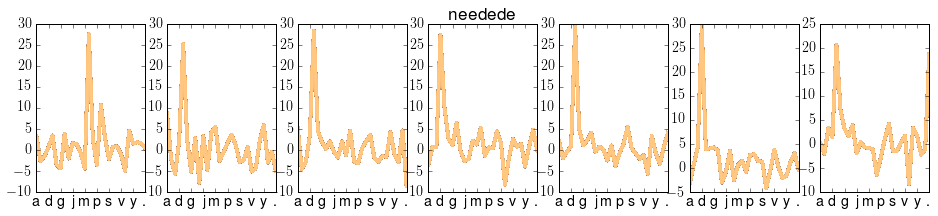

In [59]:
figure(figsize=(16,3))
cols = get_cmap('copper', n_steps)
xv = arange(0, len(alph), 3)
alph = np.array(list(alphabet))

lv = alph[xv]

for i in range(n_steps):
    ax=subplot(171)
    plot(-l1_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(172)
    plot(-l2_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(173)
    plot(-l3_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(174)
    plot(-l4_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(175)
    plot(-l5_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(176)
    plot(-l6_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(177)
    plot(-l7_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    
    
l1 = alph[np.argmax(np.abs(l1_coef_hist[-1,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[-1,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[-1,:]))]
l4 = alph[np.argmax(np.abs(l4_coef_hist[-1,:]))]
l5 = alph[np.argmax(np.abs(l5_coef_hist[-1,:]))]
l6 = alph[np.argmax(np.abs(l6_coef_hist[-1,:]))]
l7 = alph[np.argmax(np.abs(l7_coef_hist[-1,:]))]

result = l1+l2+l3+l4+l5+l6+l7
print result

subplot(174)
title(result)

fname = 'encoding_resonance_170314-res_example-all-' + all_words[idx] + '-N='  + str(N) + '-M=' + str(M) + '-n' + time.strftime('%y%m%d')
print fname

savefig(fname + '.eps', format='eps', transparent=True)
savefig(fname + '.png', format='png', transparent=True)
